In [235]:
%%bash
strace -tt -T -r -yy -o  logs/view3.st python src/mmarrays.py 100000

Data size = 819.200 MB
Chunk size = 0.800 MB


In [236]:
!cat logs/view3.st

14:43:15.667278 (+     0.000000) execve("/opt/conda/envs/hdf5-tutorial/bin/python", ["python", "src/mmarrays.py", "100000"], 0x7fffe493f9c0 /* 59 vars */) = 0 <0.000715>
14:43:15.668704 (+     0.001253) brk(NULL) = 0x559b9be3f000 <0.000036>
14:43:15.669200 (+     0.000490) readlink("/proc/self/exe", "/opt/conda/envs/hdf5-tutorial/bi"..., 4096) = 44 <0.000094>
14:43:15.669436 (+     0.000233) access("/etc/ld.so.preload", R_OK) = -1 ENOENT (No such file or directory) <0.000034>
14:43:15.669675 (+     0.000234) openat(AT_FDCWD, "/opt/conda/envs/hdf5-tutorial/bin/../lib/tls/haswell/x86_64/libpthread.so.0", O_RDONLY|O_CLOEXEC) = -1 ENOENT (No such file or directory) <0.000075>
14:43:15.669985 (+     0.000312) stat("/opt/conda/envs/hdf5-tutorial/bin/../lib/tls/haswell/x86_64", 0x7ffecb7173d0) = -1 ENOENT (No such file or directory) <0.000138>
14:43:15.670643 (+     0.000664) openat(AT_FDCWD, "/opt/conda/envs/hdf5-tutorial/bin/../lib/tls/haswell/libpthread.so.0", O_RDONLY|O_CLOEXEC) = -1 ENOE

In [3]:
import re

In [33]:
inp_str = 'read(3</etc/locale.alias>,s(),dd) = 0 <1.22>'
#pattern = r'read\((.*?)\)[^)]*$'
pattern = r'<(.*?)>'
match = re.search(pattern, inp_str)
match.group(1)

'/etc/locale.alias'

In [95]:
inp_str = '/workspaces/hdf5-tutorial/libs/strace_miner/dev/src/mmarrays.py'
if '/workspaces/hdf5-tutorial' in inp_str:
    print("found")

found


In [1]:
from strace_miner.core.strace_line_reader import StraceLineReader
from strace_miner.core.strace_analyzer import StraceAnalyzer
from strace_miner.core.preprocessor import Preprocessor

In [40]:
%%writefile ../strace_miner/views/v3/io_line_reader.py

from ...core.strace_line_reader import StraceLineReader

class IOLineReaderV3(StraceLineReader):
    def __init__(self,prefixes=None,collapse=False):
        super().__init__()
        self.prefixes = prefixes
        self.collapse = collapse    

    def get_bytes(self,call):
        if not call in ['read','write']:
            return '0'
        pattern = r'{}\((.*?)\)[^)]*$'.format(call)
        ret = self.match_pattern(pattern).split(',')
        bytes = int(ret[-1])

        if bytes < 1024*4:
            val = '[<4KB]'
        elif bytes < 1024*1024*4:
            val = '[<4MB]'
        else:
            val = '[>4MB]'
        
        return val
    
    def _get_concise_path(self,path,file_name=False):
        components = path.split('/')
        if len(components) < 3:
            pass
        else:
            path = "/{}/{}".format(components[1],components[2])
            if file_name:
                if len(components)>3:
                    path = path + ".../{}".format(components[-1])
        return path
    
    def get_fs(self,call):
        if not call in ['read','write']:
            return ' '
        
        pattern = r'<(.*?)>' 
        val = self.match_pattern(pattern)

        if not self.collapse:
            path = self._get_concise_path(val)
        else:
            path = " "
        if self.prefixes:
            for prefix in self.prefixes:
                if prefix in val:
                    path = self._get_concise_path(val,file_name=True)
        return path                    



    def parse_call_attrs(self,call):
        bytes = self.get_bytes(call)
        fs = self.get_fs(call)
        return [bytes,fs]

Writing ../strace_miner/views/v3/io_line_reader.py


In [3]:
lr = IOLineReaderV3(collapse=False)
line = '09:55:36.270878 (+     0.002224) read(3</workspaces/hdf5-tutorial/libs/strace_miner/dev/src/mmarrays.py>, "t(CHUNK_SIZE*8*1e-6))", 4096) = 22 <0.000190>'
lr.set_line(line)

In [4]:
attrs = lr.parse_attrs()
attrs

['read', '09:55:36.270878', 0.00019]

In [5]:
bytes, fs = lr.parse_call_attrs(attrs[0])
bytes,fs

('[<4MB]', '/workspaces/hdf5-tutorial')

In [41]:
%%writefile ../strace_miner/views/v3/io_miner_v3.py
from ...core.strace_analyzer import StraceAnalyzer
from ...core.preprocessor import Preprocessor

import os
import pm4py
import pandas as pd


class IOMinerV3(StraceAnalyzer):
    def __init__(self,st_log_paths,io_calls,line_reader):
        super().__init__(st_log_paths)
        self.io_calls = io_calls
        self.line_reader = line_reader
        self.activities_summary = {}
    
    def process_line(self, line):
        self.line_reader.set_line(line)
        attrs = self.line_reader.parse_attrs()
        call_attrs = self.line_reader.parse_call_attrs(attrs[0])
        return attrs+call_attrs
    
    def preprocess(self, reuse=False):
        for st_path in self.st_log_paths: 
              st = Preprocessor(st_path,self.io_calls,'IO')
              st.extra = ['bytes','fs']
              case_id = os.path.basename(st_path).split('.st')[0]
              if not reuse:
                st.prepare_csv_log(self.process_line)
            
              self.st_logs[case_id] = st
    
    def _get_activities_summaries(self,df,st):
          ## find the total duration of each activity
          summary = []
          grouped = df.groupby('concept')
          sum_by_call = dict(grouped['duration'].sum())      
          for call,dur in sum_by_call.items():
               p_tot = (dur/st.total_time)*100.0
               p_sys = (dur/st.sys_time)*100.0      
               summary.append([call.split('\n'),dur,p_tot,p_sys])
          return pd.DataFrame(summary,columns=st.stat_cols)
    
    def prepare_summaries_and_event_log(self):
         df_all = []
         for case_id,st in self.st_logs.items():
              df = st.get_df_from_csv()
              summary, df = st.process(df)
              self.summaries[case_id] = summary
              df['case'] = case_id
              df['concept'] = df['call'] + '\n' + df['bytes'].astype(str) + '\n' + df['fs']
              self.activities_summary[case_id] = self._get_activities_summaries(df,st)

              df = pm4py.format_dataframe(df,case_id='case',activity_key='concept',timestamp_key='time')
              df_all.append(df)

         self.el = pm4py.convert_to_event_log(pd.concat(df_all,ignore_index=True))


    def prepare_dfg(self):
         self.dfg,self.dfg_im,self.dfg_fm = pm4py.discover_dfg(self.el)

    def view_dfg(self):
         if self.dfg:
              return pm4py.view_dfg(self.dfg,self.dfg_im,self.dfg_fm)

Writing ../strace_miner/views/v3/io_miner_v3.py


In [32]:
io_calls = ['read','write','mmap']
line_reader = IOLineReaderV3(collapse=False)
sta = IOMinerV3(["logs/view3.st",],io_calls,line_reader)

In [33]:
sta.preprocess()

CSV log path: logs/view3.csv


In [34]:
sta.st_logs[list(sta.st_logs.keys())[0]].get_df_from_csv()

,call,time,duration,bytes,fs
0,execve,14:43:15.667278,0.000715,0,
1,brk,14:43:15.668704,0.000036,0,
2,readlink,14:43:15.669200,0.000094,0,
3,access,14:43:15.669436,0.000034,0,
4,openat,14:43:15.669675,0.000075,0,
...,...,...,...,...,...
12780,munmap,14:43:19.733501,0.000052,0,
12781,munmap,14:43:19.733639,0.000068,0,
12782,munmap,14:43:19.733814,0.000062,0,
12783,exit_group,14:43:19.734349,0.000000,0,


In [35]:
sta.prepare_summaries_and_event_log()
sta.prepare_dfg()

/home/vscode/.local/lib/python3.12/site-packages/pm4py/utils.py:538: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


In [37]:
sta.activities_summary['view3']

,call,duration,percent_total,percent_sys
0,"[mmap, 0, ]",0.031863,0.782745,1.500656
1,"[read, [<4KB], /dev/urandom<char 1:9]",0.000141,0.003464,0.006641
2,"[read, [<4KB], /home/vscode]",0.000031,0.000762,0.001460
3,"[read, [<4KB], /lib/x86_64-linux-gnu]",0.000509,0.012504,0.023972
4,"[read, [<4KB], /opt/conda]",0.048808,1.199015,2.298717
5,"[read, [<4KB], /workspaces/hdf5-tutorial]",0.000064,0.001572,0.003014
6,"[read, [<4MB], /etc/locale.alias]",0.000154,0.003783,0.007253
7,"[read, [<4MB], /home/vscode]",0.000156,0.003832,0.007347
8,"[read, [<4MB], /opt/conda]",0.057068,1.401930,2.687740
9,"[read, [<4MB], /proc/stat]",0.000240,0.005896,0.011303


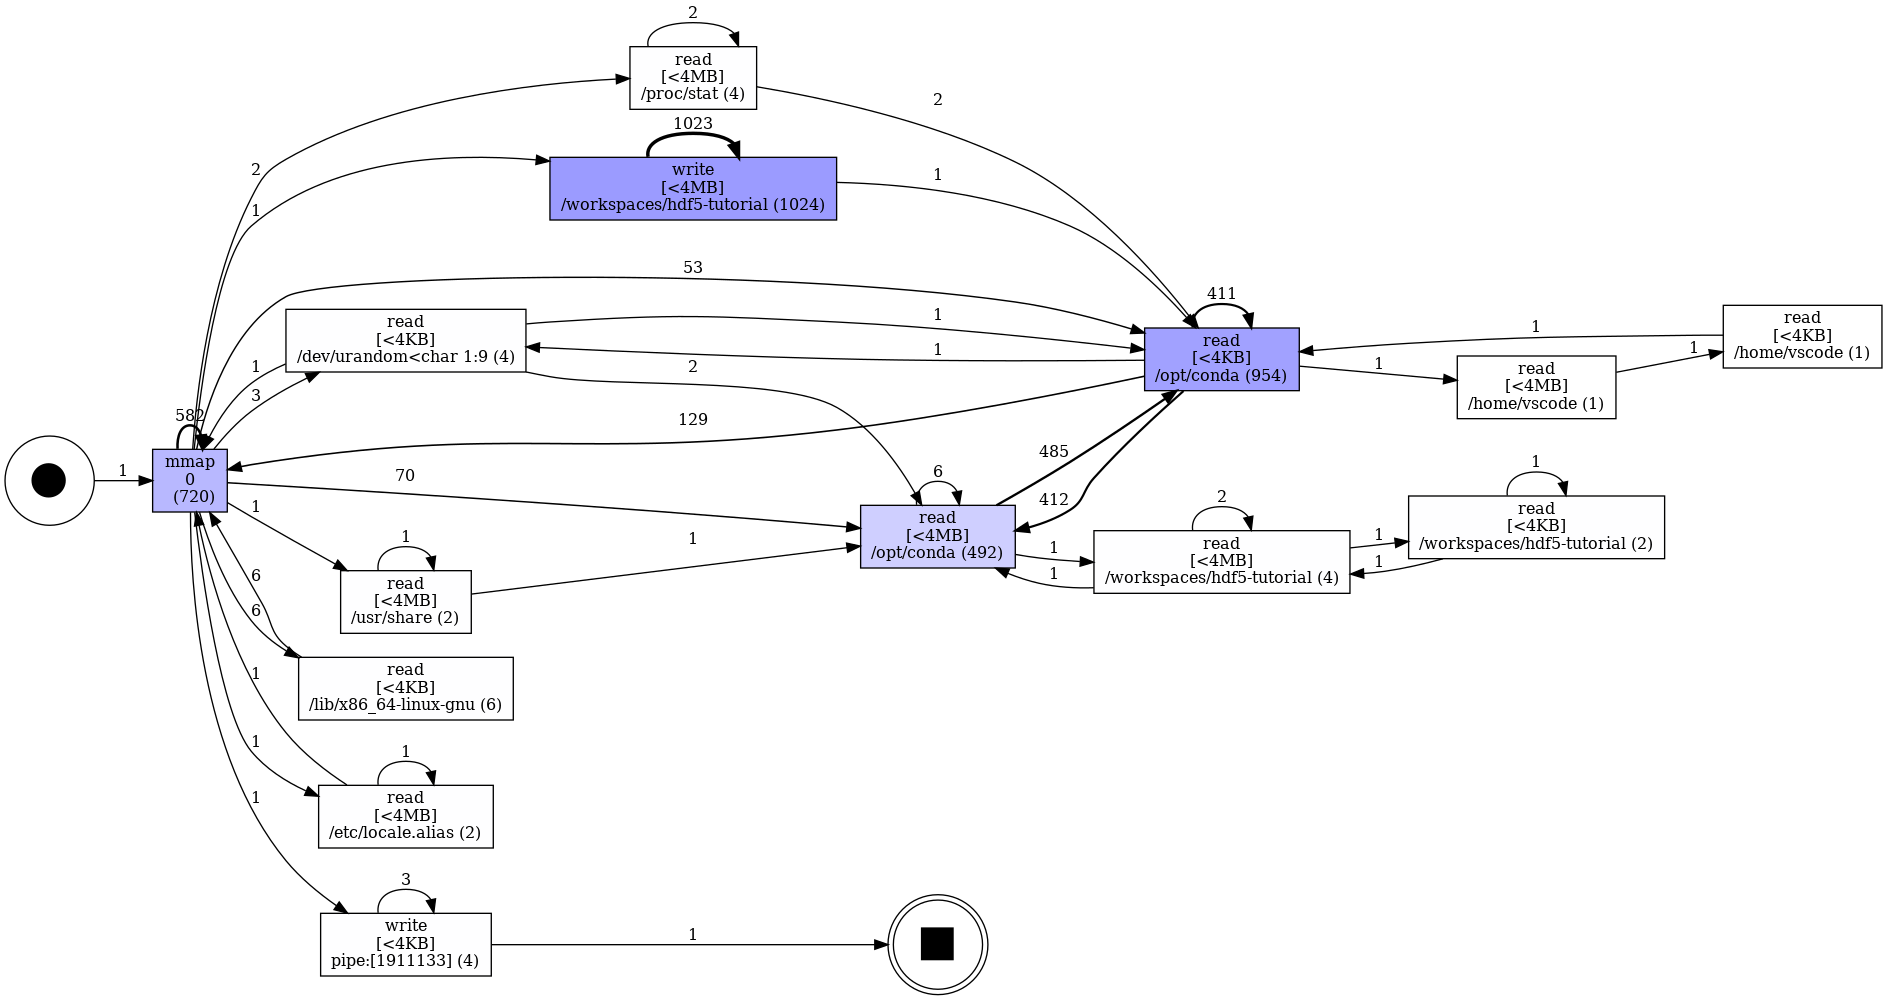

In [38]:
sta.view_dfg()

In [268]:
sta.summaries['view3']

,call,duration,percent_total,percent_sys
0,Total,4.070673,100.000000,-1.000000
1,Sys time,2.123271,52.160196,100.000000
2,IO time,1.540514,37.844209,72.553810
3,Remaining sys time,0.582757,14.315987,27.446190
4,mmap,0.031863,0.782745,1.500656
5,read,0.107373,2.637721,5.056962
6,write,1.401278,34.423743,65.996192
